#  DATA512 HW1 using Page Views API
This code uses page view data using the [Wikimedia REST API](https://www.mediawiki.org/wiki/Wikimedia_REST_API). It requests monthly counts of page views for specific articles that is read separately as an Excel file. We then produce some graphs as a part of data analysis.
The API documentation, [pageviews/per-article](https://wikimedia.org/api/rest_v1/#/Pageviews%20data), covers additional details that may be helpful when trying to use or understand this example.

## License
This code has some parts from the example that was developed by Dr. David W. McDonald for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.2 - August 14, 2023.
Adithyaa Vaasen is the author and the owner of this particular notebook.


## Import Libraries
Load all required libraries


In [1]:
import warnings
warnings.filterwarnings("ignore")

import json, time, urllib.parse
import requests
import pandas as pd
from itertools import islice
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

## Set Global Variables for the Pageviews API

This section parameters for making requests to the Wikimedia REST API, specifically for retrieving page view data. These parameters are used to construct the API requests. Some of the values in 'ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE' may be changed as needed for specific requests.

In [2]:
start = time.time()

In [3]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<adi279@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}


# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start date
    "end":         "2023093000"    # end date
}


## Function for calling the Pageviews API for multiple articles

The `request_pageviews_per_article` function is responsible for making API requests to retrieve pageview data for a specified Wikipedia article.

1. **Function Parameters:**
   - `article_title`: The title of the Wikipedia article for which pageview data is requested.
   - `access`: The access type for which pageview data is requested. We will be changing this.
   - `endpoint_url`: The base URL of the Wikimedia Pageviews API.
   - `endpoint_params`: A parameterized string that specifies the API request parameters.
   - `request_template`: A dictionary containing parameter values for the API request.
   - `headers`: Request headers, including user agent information.


2. **Article Title Handling:**
   - The function allows passing the `article_title` as a parameter or within the `request_template`.
   - It ensures that a valid article title is provided; otherwise, it raises an exception.


3. **URL Encoding:**
   - The function URL-encodes the article title by replacing spaces with underscores and ensures safe encoding.
   - The encoded title is set in the `request_template`.


4. **Access Type Modification:**
   - If the `access` parameter is provided, the function modifies the `access` field in the `request_template` accordingly.


5. **Request URL Construction:**
   - The function constructs the complete request URL by combining the `endpoint_url` with the formatted `endpoint_params`.


6. **API Request and Throttling:**
   - It makes an HTTP GET request to the constructed URL, including the specified headers.
   - It incorporates throttling, waiting for a specified time (`API_THROTTLE_WAIT`) to avoid exceeding API limits.
   - If an exception occurs during the request, it captures the error message and returns `None`.


7. **JSON Response:**
   - The function attempts to parse the API response as JSON and returns the JSON data.



In [4]:
def request_pageviews_per_article(article_title=None, access = None,
                                  endpoint_url=API_REQUEST_PAGEVIEWS_ENDPOINT,
                                  endpoint_params=API_REQUEST_PER_ARTICLE_PARAMS,
                                  request_template=ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers=REQUEST_HEADERS):

    # article title can be passed as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ', '_'), safe='')
    request_template['article'] = article_title_encoded

    # Modify the access parameter in the request template if specified
    if access:
        request_template['access'] = access

    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url + endpoint_params.format(**request_template)

    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Get pageview data

### Set-up: 

This code block serves as the initial step before collecting and processing data for a set of articles.

1. **Date Range Definition:**
   - It defines the start and end dates as integer text in the YYYYMM format. These dates represent the time range for collecting pageview data.


2. **Data Storage Initialization:**
   - It initializes three dictionaries to store different types of pageview data: `mobile_data`, `desktop_data`, and `cumulative_data`. These dictionaries will be populated with collected data.


3. **Reading Data from XLSX File:**
   - It reads ARTICLE_TITLES from an XLSX file named 'thank_the_academy.AUG.2023.csv.xlsx' into a DataFrame called `df`.
   - The DataFrame contains information about articles, including their titles.



In [5]:
# Define the start and end dates as integer text (YYYYMM format)
start_date = "201507"
end_date = "202309"

# Initialize dictionaries to store mobile, desktop, and cumulative data
mobile_data = {}
desktop_data = {}
cumulative_data = {}

# Read ARTICLE_TITLES from the XLSX file
xlsx_filename = 'thank_the_academy.AUG.2023.csv.xlsx'

# Setting a count variable to track the number of titles
title_count = 1

# Load the XLSX file into a DataFrame
df = pd.read_excel(xlsx_filename)

### Data Collection: 

This code block is responsible for collecting and processing data for a set of articles by making API requests to gather pageview statistics. The code operates in the following steps:

1. **Iteration Over DataFrame Rows:**
   - It iterates over each row of a DataFrame named `df`.
   - For each row, it extracts the value in the 'name' column and assigns it to the variable `article_title`.


2. **API Requests for Mobile Views:**
   - It makes two separate API requests for mobile views for each `article_title`:
     - `mobile_app_views`: Requests pageview data for "mobile-app" access.
     - `mobile_web_views`: Requests pageview data for "mobile-web" access.


3. **Total Mobile Views Calculation:**
   - It calculates the total mobile views for each month by summing the views from "mobile-app" and "mobile-web" for the same month.
   - This is done by iterating over the corresponding months in both `mobile_app_views` and `mobile_web_views`.


4. **API Request for Desktop Views:**
   - It makes a single API request for desktop views using the same `article_title` but with access set to "desktop".


5. **Data Storage:**
   - The collected data is stored in dictionaries:
     - `mobile_data`: Contains mobile view data for the current `article_title`.
     - `desktop_data`: Contains desktop view data for the current `article_title`.
     - `cumulative_data`: Contains monthly cumulative data (sum of mobile and desktop views) for the current `article_title`.


6. **Saving Data to JSON Files:**
   - After processing all articles, the code saves the collected data to JSON files:
     - `academy_monthly_mobile_{start_date}-{end_date}.json`: Contains mobile view data.
     - `academy_monthly_desktop_{start_date}-{end_date}.json`: Contains desktop view data.
     - `academy_monthly_cumulative_{start_date}-{end_date}.json`: Contains monthly cumulative data.


In [6]:
for index, row in df.iterrows():
    article_title = row['name']
    print(str(title_count) + ': ' + article_title)
    
    title_count = title_count + 1
    
    # Make separate API requests for "mobile-app" access
    mobile_app_views = request_pageviews_per_article(article_title, access="mobile-app")

    # Make separate API requests for "mobile-web" access
    mobile_web_views = request_pageviews_per_article(article_title, access="mobile-web")

    # Calculate the total mobile views (sum of "mobile-app" and "mobile-web")
    total_mobile_views = [
        month_app['views'] + month_web['views']
        for month_app, month_web in zip(mobile_app_views['items'], mobile_web_views['items'])
    ]

    # Make a single API request for desktop access
    desktop_views = request_pageviews_per_article(article_title, access="desktop")

    # Store the data in the appropriate dictionaries
    mobile_data[article_title] = {
        'mobile': [
            {
                'timestamp': month['timestamp'],
                'views': total_mobile_views[i]
            }
            for i, month in enumerate(desktop_views['items'])
        ]
    }
    desktop_data[article_title] = desktop_views['items']

    # Calculate monthly cumulative data as sum of mobile and desktop views
    cumulative_data[article_title] = [{
        'timestamp': month['timestamp'],
        'views': month['views'] + total_mobile_views[i]
    } for i, month in enumerate(desktop_views['items'])]
        
# Save the data to JSON files
with open(f"academy_monthly_mobile_{start_date}-{end_date}.json", "w") as mobile_file:
    json.dump(mobile_data, mobile_file, indent=4)

with open(f"academy_monthly_desktop_{start_date}-{end_date}.json", "w") as desktop_file:
    json.dump(desktop_data, desktop_file, indent=4)

with open(f"academy_monthly_cumulative_{start_date}-{end_date}.json", "w") as cumulative_file:
    json.dump(cumulative_data, cumulative_file, indent=4)

1: Everything Everywhere All at Once
2: All Quiet on the Western Front (2022 film)
3: The Whale (2022 film)
4: Top Gun: Maverick
5: Black Panther: Wakanda Forever
6: Avatar: The Way of Water
7: Women Talking (film)
8: Guillermo del Toro's Pinocchio
9: Navalny (film)
10: The Elephant Whisperers
11: An Irish Goodbye
12: The Boy, the Mole, the Fox and the Horse (film)
13: RRR (film)
14: CODA (2021 film)
15: Dune (2021 film)
16: The Eyes of Tammy Faye (2021 film)
17: No Time to Die
18: The Windshield Wiper
19: The Long Goodbye (Riz Ahmed album)
20: The Queen of Basketball
21: Summer of Soul
22: Drive My Car (film)
23: Encanto
24: West Side Story (2021 film)
25: Belfast (film)
26: The Power of the Dog (film)
27: King Richard (film)
28: Cruella (film)
29: Nomadland (film)
30: The Father (2020 film)
31: Judas and the Black Messiah
32: Minari (film)
33: Mank
34: Sound of Metal
35: Ma Rainey's Black Bottom (film)
36: Promising Young Woman
37: Tenet (film)
38: Soul (2020 film)
39: Another Round 

## Analysis

### Post Processing:
This code helps in preparing the data for subsequent analysis and visualization tasks.

1. Flatten the desktop, mobile & cumulative data, which is stored as a dictionary of dictionaries, into a list of dictionaries. It iterates through each article's monthly data and extracts the article name, timestamp, and views, creating a flattened structure. 


2. Converts it into a Pandas DataFrame. The 'timestamp' column is also converted to a datetime format using the '%Y%m%d%H' format.


3. Results in three separate DataFrames: `cumulative_df`, `desktop_df`, and `mobile_df`. 



In [7]:
# Flatten cumulative data

cumulative_list = []
for name, monthly_data in cumulative_data.items():
    for month in monthly_data:
        cumulative_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
cumulative_df = pd.DataFrame(cumulative_list)
cumulative_df['timestamp'] = pd.to_datetime(cumulative_df['timestamp'], format='%Y%m%d%H')

# Flatten desktop data
desktop_list = []
for name, monthly_data in desktop_data.items():
    for month in monthly_data:
        desktop_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
desktop_df = pd.DataFrame(desktop_list)
desktop_df['timestamp'] = pd.to_datetime(desktop_df['timestamp'], format='%Y%m%d%H')


# Flatten mobile data
mobile_list = []
for name, monthly_data in mobile_data.items():
    for month in monthly_data["mobile"]:
        mobile_list.append({
            "name": name,
            "timestamp": month["timestamp"],
            "views": month["views"]
        })

# Convert to a Pandas DataFrame
mobile_df = pd.DataFrame(mobile_list)
mobile_df['timestamp'] = pd.to_datetime(mobile_df['timestamp'], format='%Y%m%d%H')

## Analysis

In this section we will conduct a very basic visual analysis. The analysis for this homework is to graph specific subsets of the data as a timeseries. You will produce three different graphs.
1. Maximum Average and Minimum Average - The first graph should contain time series for the articles that have the highest average monthly page requests and the lowest average monthly page requests for desktop access and mobile access. Your graph should have four lines (max desktop, min desktop, max mobile, min mobile).

Method:
1. Calculate the average monthly page requests for both desktop and mobile access.
2. Identify articles with the highest and lowest average monthly page requests for each access type.
3. Filter the data for these articles.
4. Sort the data frames by timestamp.
5. Create a time series graph with four lines: Max Desktop, Min Desktop, Max Mobile, and Min Mobile.

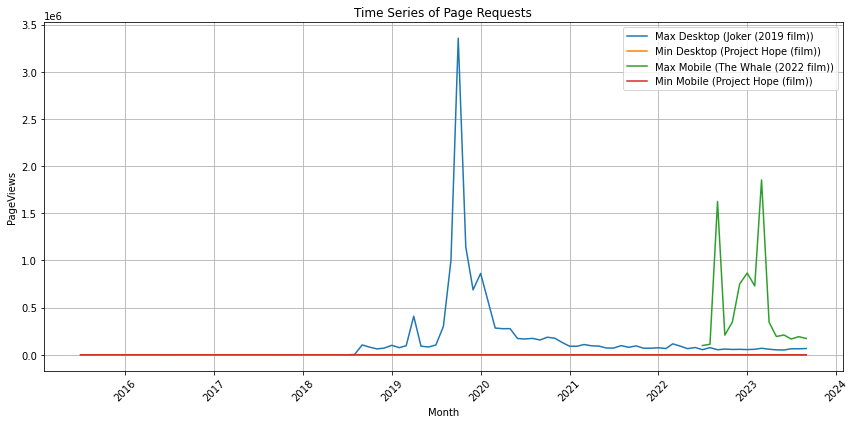

<Figure size 432x288 with 0 Axes>

In [8]:
# Calculate average monthly page requests for desktop and mobile access
desktop_avg = desktop_df.groupby("name")["views"].mean()
mobile_avg = mobile_df.groupby("name")["views"].mean()

# Find articles with highest and lowest average monthly page requests
max_desktop_article = desktop_avg.idxmax()
min_desktop_article = desktop_avg.idxmin()
max_mobile_article = mobile_avg.idxmax()
min_mobile_article = mobile_avg.idxmin()

# Filter data for these articles
max_desktop_data = desktop_df[desktop_df["name"] == max_desktop_article]
min_desktop_data = desktop_df[desktop_df["name"] == min_desktop_article]
max_mobile_data = mobile_df[mobile_df["name"] == max_mobile_article]
min_mobile_data = mobile_df[mobile_df["name"] == min_mobile_article]

# Sort the data frames by timestamp
max_desktop_data = max_desktop_data.sort_values(by="timestamp")
min_desktop_data = min_desktop_data.sort_values(by="timestamp")
max_mobile_data = max_mobile_data.sort_values(by="timestamp")
min_mobile_data = min_mobile_data.sort_values(by="timestamp")

# Create the time series graph
plt.figure(figsize=(12, 6))
plt.plot(max_desktop_data["timestamp"], max_desktop_data["views"], label=f"Max Desktop ({max_desktop_article})")
plt.plot(min_desktop_data["timestamp"], min_desktop_data["views"], label=f"Min Desktop ({min_desktop_article})")
plt.plot(max_mobile_data["timestamp"], max_mobile_data["views"], label=f"Max Mobile ({max_mobile_article})")
plt.plot(min_mobile_data["timestamp"], min_mobile_data["views"], label=f"Min Mobile ({min_mobile_article})")
plt.xlabel("Month")
plt.ylabel("PageViews")
plt.title("Time Series of Page Requests")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('MaximumMinimumAverage.png')

2. Top 10 Peak Page Views - The second graph should contain time series for the top 10 article pages by largest (peak) page views over the entire time by access type. You first find the month for each article that contains the highest (peak) page views, and then order the articles by these peak values. Your graph should contain the top 10 for desktop and top 10 for mobile access (20 lines).

Method:
1. Get the month with the highest page views (peak) for each article for desktop and mobile access separately.
2. Create data frames containing the peak data for desktop and mobile access.
3. Sort the articles by their peak page views in descending order.
4. Select the top 10 articles with the highest peak views for desktop and mobile access.
5. Plot the time series of these top 10 articles for both desktop and mobile access on the same graph, labeling each line appropriately.

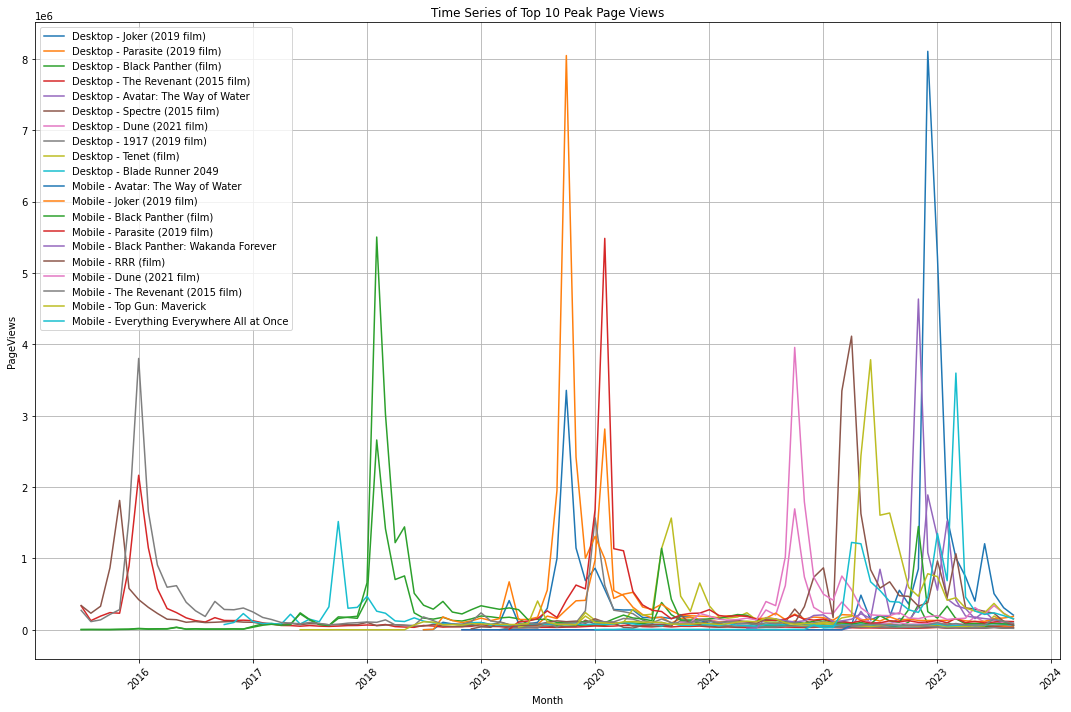

<Figure size 432x288 with 0 Axes>

In [9]:
# Find the month with the highest page views (peak) for each article for desktop access
desktop_peak_months = desktop_df.groupby("name")["views"].idxmax()
desktop_peak_data = desktop_df.loc[desktop_peak_months]

# Find the month with the highest page views (peak) for each article for mobile access
mobile_peak_months = mobile_df.groupby("name")["views"].idxmax()
mobile_peak_data = mobile_df.loc[mobile_peak_months]

# Sort articles by peak page views for desktop and mobile access
top_desktop_articles = desktop_peak_data.sort_values(by="views", ascending=False).head(10)
top_mobile_articles = mobile_peak_data.sort_values(by="views", ascending=False).head(10)

# Create the time series graph for the top 10 articles for desktop and mobile access
plt.figure(figsize=(15, 10))

# Plot top 10 desktop articles
for _, article in top_desktop_articles.iterrows():
    plt.plot(desktop_df[desktop_df["name"] == article["name"]]["timestamp"], desktop_df[desktop_df["name"] == article["name"]]["views"], label=f"Desktop - {article['name']}")

# Plot top 10 mobile articles
for _, article in top_mobile_articles.iterrows():
    plt.plot(mobile_df[mobile_df["name"] == article["name"]]["timestamp"], mobile_df[mobile_df["name"] == article["name"]]["views"], label=f"Mobile - {article['name']}")

plt.xlabel("Month")
plt.ylabel("PageViews")
plt.title("Time Series of Top 10 Peak Page Views")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('Top10PeakPageViews.png')

3. Fewest Months of Data - The third graph should show pages that have the fewest months of available data. These will all be relatively short time series and should contain a set of the most recent academy award winners. Your graph should show the 10 articles with the fewest months of data for desktop access and the 10 articles with the fewest months of data for mobile access.

Method:
1. Get the number of months of data for each article for desktop and mobile access.
2. Sort articles by the fewest months for both desktop and mobile.
3. Create a time series graph for the top 10 articles with the fewest months of data.

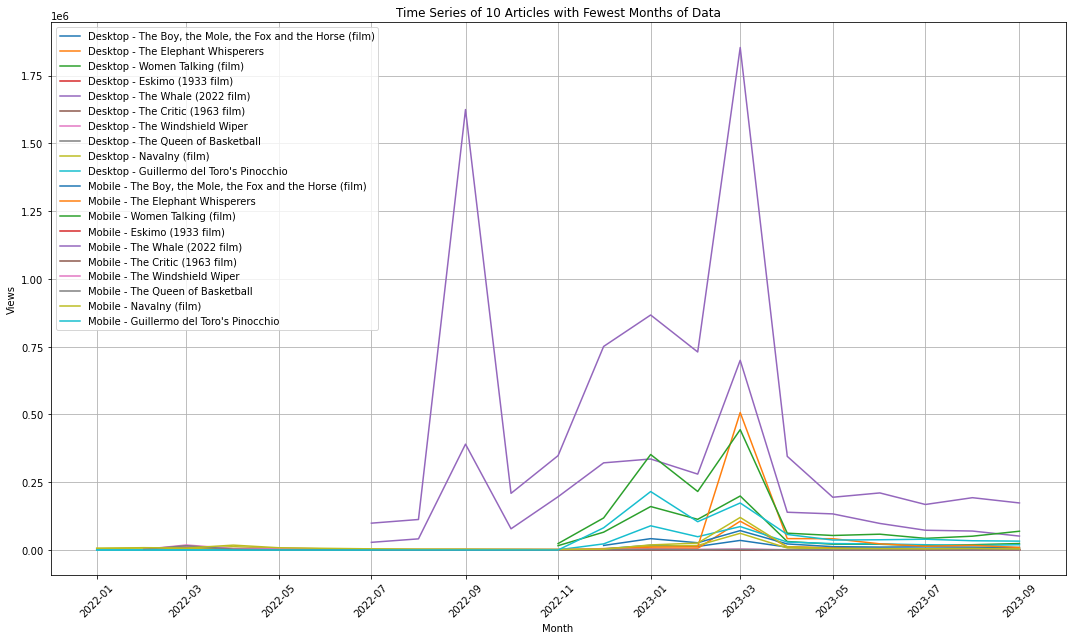

<Figure size 432x288 with 0 Axes>

In [10]:
# Calculate the number of months of data available for each article for desktop access
desktop_data_months = desktop_df.groupby("name")["timestamp"].nunique()
desktop_data_months = desktop_data_months.reset_index(name="num_months")

# Calculate the number of months of data available for each article for mobile access
mobile_data_months = mobile_df.groupby("name")["timestamp"].nunique()
mobile_data_months = mobile_data_months.reset_index(name="num_months")

# Sort articles by the fewest months of data for desktop and mobile access
top_fewest_desktop_articles = desktop_data_months.sort_values(by="num_months").head(10)
top_fewest_mobile_articles = mobile_data_months.sort_values(by="num_months").head(10)

# Create the time series graph for the 10 articles with the fewest months of data
plt.figure(figsize=(15, 9))

# Plot top 10 articles with the fewest months of data for desktop access
for _, article in top_fewest_desktop_articles.iterrows():
    plt.plot(desktop_df[desktop_df["name"] == article["name"]]["timestamp"], desktop_df[desktop_df["name"] == article["name"]]["views"], label=f"Desktop - {article['name']}")

# Plot top 10 articles with the fewest months of data for mobile access
for _, article in top_fewest_mobile_articles.iterrows():
    plt.plot(mobile_df[mobile_df["name"] == article["name"]]["timestamp"], mobile_df[mobile_df["name"] == article["name"]]["views"], label=f"Mobile - {article['name']}")

plt.xlabel("Month")
plt.ylabel("Views")
plt.title("Time Series of 10 Articles with Fewest Months of Data")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.savefig('FewestMonths.png')

In [11]:
print(f'Time taken to run: {time.time() - start:.1f}')

Time taken to run: 3894.6
